# Train, fit, and evaluate classifier <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


TODO:
- if/when datasets become large, consider implementing `dask_ml`

## Background

blahblahblah


_Table 1: Some of the pros and cons of different classifiers available through scikit-learn_

<img align="center" src="classifier_pro_cons.PNG" width="700">

## Description

1. Split the training data into a training set and a test set
2. Optionally standardise the datasets
2. Train a classifier
3. Evaluate the classifier using a number of metrics
4. Optimise the model hyperparameters
5. Retrain the model using the optimised hyperparameters
6. Re-evaluate the classifier using a number of metrics
7. Optionally plot Receiver Operating Characteristic (ROC) Curves (for binary classification only)
6. Save model to disk

## Load packages

In [1]:
# -- scikit-learn classifiers, uncomment the one of interest----

# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

import os
import pandas as pd
import numpy as np
from joblib import dump
import subprocess as sp
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `Classifier`: This parameter refers to the scikit-learn classification model to use, first uncomment the classifier of interest in the `Load Packages` section and then enter the function name into this parameter `e.g. Classifier = SVC`   
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `ncpus`: Set this value to > 1 to parallize the model fitting eg. npus=8. 
* `metrics` : A single str or a list of strings to evaluate the predictions on the test set. See the scoring parameter page [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a pre-defined list of options
* `cv` : Determines the number of k-fold cross-validations to conduct during testing of the model.  A higher number will reduce the possibility of over-fitting, but will require more time to compute. 5 is a good default number.

In [2]:
training_data = "results/training_data/test_training_data.txt"

Classifier = RandomForestClassifier

class_dict = {'crop':1, 'noncrop':0}

ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))

metrics = 'f1' #good for binary classifications

cv = 10

print('ncpus = '+str(ncpus))

ncpus = 15


## Import training data

In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

## Split into training and testing data

Here will split the training data into four seperate datasets:
* `train_features` : the feature layer data we will train the classifier on
* `test_features` :  the feature layer data we will use to test the accuracy/precision of our classifier
* `train_labels` : the dependent variables we will train the classifier on (in the default example the integers that represent the classes i.e. 1. and 0.)
* `test_labels` : the dependent variables we will use to test the accuracy/precision of our classifier.

Set the `test_size` to a fraction between 0 and 1, this will determine what fraction of the dataset will be set aside as the testing dataset. There is a trade-off here between having a larger test set that will help us better determine the quality of our classifier, and leaving enough data to train the classifier. A good deafult is to set 20 % of your dataset aside for testing purposes.

In [4]:
test_size = 0.2

In [5]:
train_features, test_features, train_labels, test_labels = train_test_split(model_input[:, model_col_indices],
                                                                  model_input[:, 0],
                                                                  test_size=test_size, 
                                                                  random_state=1)
print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)

train_features shape: (220, 23)
test_features shape: (55, 23)


## Optional: Feature scaling

Feature scaling (standardisaton or normalisation) of datasets is a common requirement for many machine learning estimators. For example, the objective function within the RBF kernel of Support Vector Machines assumes that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly.

Below, we demonstrate the use of a common preprocessing function provided by [sklearn](https://scikit-learn.org/stable/modules/preprocessing.html), `StandardScaler`, which will standardise the values in an array to the array's mean and standard deviation via the formuala: `z = (x-u/s)`, where `u` is the mean of and `s` is the standard deviation.

To centre all values around 0, set `with_mean = False` within the `StandardScalar()` method

> **Note**: <ins>Always</ins> split your data into a training and test set **BEFORE** feature scaling (normalisation or standardisation) is applied. This is because the test set is intended to be a completly independent set of data. If feature scaling is applied before splitting, then the data will share a common mean and standard deviation (i.e. **information leakage** occurs between the training and test datasets).

> **Note**: <ins>Do not</ins> apply standardisation to categorical data (dummy variables).

> **Note**: If running this notebook using the default parameters, then there is no need to standardise the data since the default feature layers (surface reflectance & vegetation indices) are already normalised, and because Random Forest classifier aren't prone to these kinds of errors. 

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# Compute the mean and variance for each feature
sc = StandardScaler()

#apply standard scalar params to the training set
train_features = sc.fit_transform(train_features)

#apply the same standard scalar params to the test set
test_features = sc.fit_transform(test_features)

# apply the same standard scalar params to all the feature data, 
# this is for our hyperparamter searching later on which relies on the full dataset
model_input[:, model_col_indices] = sc.fit_transform(model_input[:, model_col_indices])

Below, we reprint the data to compare it to the original `model_input` we printed above. The values have now been transformed to express their variance around the mean and standard deviation

In [8]:
print(column_names)
print('')
print(np.array_str(train_features, precision=2, suppress_small=True))

['class', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'NDVI', 'LAI', 'sdev', 'edev', 'bcdev', 'blue_2', 'green_2', 'red_2', 'nir_2', 'swir_1_2', 'swir_2_2', 'NDVI_2', 'LAI_2', 'sdev_2', 'edev_2', 'bcdev_2', 'slope']

[[ 0.03 -0.16 -0.11 ... -0.36 -0.03  0.04]
 [ 2.66  2.26  1.73 ...  1.47  1.54  0.58]
 [-0.36 -0.18  0.28 ... -0.02  0.22 -0.5 ]
 ...
 [-0.15  0.28  1.4  ...  0.41  1.06 -0.53]
 [-0.53 -0.57 -0.9  ... -1.5  -1.64 -0.14]
 [ 2.16  2.31  2.13 ...  1.65  1.81 -0.38]]


## Train classifier

The intial model will rely on the default parameters, during hyperparameter tuning later we will refine these parameters

In [9]:
model = Classifier(random_state=1, n_jobs=ncpus, verbose=0)

In [10]:
model.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=15, random_state=1)

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Calculating the `cross-validation scores`, producing a `classification report` and a `confusion matrix`
* Finding out which feature layers (bands in the input data) are most useful for classifying, and which are not,
* Evaluating which model parameters (hyperparameters) optimize the model results 
* Plotting some of the decision trees from the random forest model to visualize how the algorithm is splitting the data


### Accuracy metrics

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.


In [11]:
#predict on the test dataset
predictions = model.predict(test_features)

In [12]:
#generate some accuracy metrics using k-fold cross-validation
score = cross_val_score(model,
                        model_input[:, model_col_indices],
                        model_input[:, 0],
                        cv=cv,
                        scoring=metrics
                       )

In [13]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Overall Accuracy ===")
accuracy = accuracy_score(test_labels, predictions)
print(round(accuracy, 3))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== All " +metrics+" Scores ===")
print(np.array_str(score, precision=2, suppress_small=True))
print('\n')
print("=== Mean "+metrics+" Score ===")
print(round(score.mean(), 2))

=== Confusion Matrix ===
[[44  1]
 [ 2  8]]


=== Overall Accuracy ===
0.945


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        45
         1.0       0.89      0.80      0.84        10

    accuracy                           0.95        55
   macro avg       0.92      0.89      0.90        55
weighted avg       0.94      0.95      0.94        55



=== All f1 Scores ===
[0.89 0.75 0.67 0.89 0.57 0.   0.89 0.6  0.75 0.67]


=== Mean f1 Score ===
0.67


### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

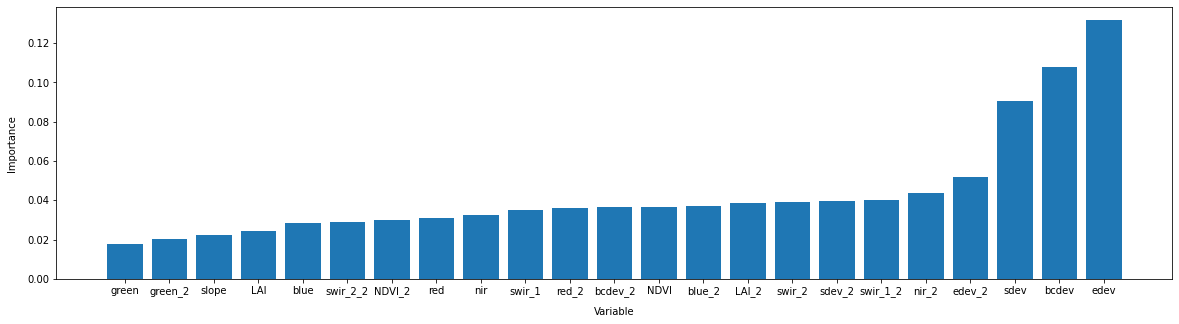

In [14]:
# This shows the feature importance of the input features for predicting the class labels provided
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(20,5))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

## Optimize hyperparameters

Hyperparameter searches are a required process in machine learning. Machine learning models require certain “hyperparameters”, model parameters that can be learned from the data. Finding these good values for these parameters is a “hyperparameter search” or an “hyperparameter optimization.”

To optimize the parameters in our model, we will take a two-step approach. Firstly, we conduct a random search over many possible paramter values to narrow our search. Secondly, using the parameters returned from the random search, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through the parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined.

* `param_grid`: Dictionary with parameters names (str) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.

> **Note**: the parameters in the `random_param_grid` object (and, later, the `param_grid` object) depend on the classifier being used. The default example is set up for a random forest classifier, to adjust ther paramaters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html). 

### Random hyperparameter grid search

* `num_of_iterations` : The number of random iterations to run with RandomSearchCV, the higher the number the more paramaters are searched, but at the cost of extra compute time.


In [15]:
num_of_iterations = 500

In [16]:
random_param_grid = {
     'bootstrap': [True, False],
     'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4, 8],
     'min_samples_split': [2, 5, 10, 20],
     'n_estimators': [100, 200, 300, 400, 500]
}


In [17]:
# Instantiate the random search model
random_grid_search = RandomizedSearchCV(model,
                           random_param_grid,
                           n_iter = num_of_iterations,
                           scoring=metrics,
                           cv=cv,
                           n_jobs=ncpus)

# Pass in the entire dataset to .fit
random_grid_search.fit(model_input[:, model_col_indices], model_input[:, 0])

print("The most accurate combination of tested parameters is: ")
pprint(random_grid_search.best_params_)


The most accurate combination of tested parameters is: 
{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}


### Grid Search with Cross Validation

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with `GridSearchCV`, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10,15,20],
    'max_features': ["auto", 'sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [4,5,6,7],
    'n_estimators': [75,100,125,150]
}

# Instantiate the grid search model
grid_search = GridSearchCV(model,
                           param_grid, 
                           scoring=metrics,
                           cv=cv,
                           n_jobs=ncpus)

# Pass in the entire dataset to .fit
grid_search.fit(model_input[:, model_col_indices], model_input[:, 0])

print("The most accurate combination of tested parameters is: ")
pprint(grid_search.best_params_)

The most accurate combination of tested parameters is: 
{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 100}


## Retrain model

Using the best parameters from our hyperparmeter optmization search, we now rerun our model and re-test its accuracy.

In [19]:
new_model = Classifier(**grid_search.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_split=7,
                       n_jobs=15, random_state=1)

### Accuracy metrics

In [20]:
predictions = new_model.predict(test_features)

In [21]:
new_score = cross_val_score(new_model,
                        model_input[:, model_col_indices],
                        model_input[:, 0],
                        cv=cv,
                        scoring=metrics)

In [22]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Overall Accuracy ===")
new_accuracy = accuracy_score(test_labels, predictions)
print(round(new_accuracy, 2))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== All " +metrics+" Scores ===")
print(np.array_str(new_score, precision=2, suppress_small=True))
print('\n')
print("=== Mean "+metrics+" Score ===")
print(round(new_score.mean(), 2))

=== Confusion Matrix ===
[[41  4]
 [ 2  8]]


=== Overall Accuracy ===
0.89


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        45
         1.0       0.67      0.80      0.73        10

    accuracy                           0.89        55
   macro avg       0.81      0.86      0.83        55
weighted avg       0.90      0.89      0.89        55



=== All f1 Scores ===
[0.8  0.67 0.6  0.89 0.57 0.29 0.89 0.67 0.75 0.6 ]


=== Mean f1 Score ===
0.67


In [23]:
print("Improvement in "+metrics+" score:")
print(new_score.mean() - score.mean())
print('\n')
print("Improvement in overall accuracy:")
print((new_accuracy - accuracy))

Improvement in f1 score:
0.0046825396825398435


Improvement in overall accuracy:
-0.054545454545454564


## Optional: Receiver Operating Characteristic (ROC) Curve

> **Note** :This is for binary classifications only

The final metric we use to evaluate our classifier is to plot the Receiver Operating Characteristic (ROC) curve. An ROC curve is an excellent method of measuring the performance of a classification model. The True Positive Rate (TPR) is plot against the False Positive Rate (FPR) for the probabilities of a classifier predictions. The area under the plot is calculated.

**The higher the area under the curve (AUC), the better the model is at distinguishing the classes**.

The steps are as follows:

1. Calculate probabilities of the classification using predict_proba
2. Select a class you want to plot, in this case the second class (with label 1.0)
3. Using `sklearn.metrics.roc_curve`, calculate the TPR and the FPR.
4. Plot TPR on the y-axis and FPR on the x-axis.
5. Calculate the area under this curve using `sklearn.metrics.auc`

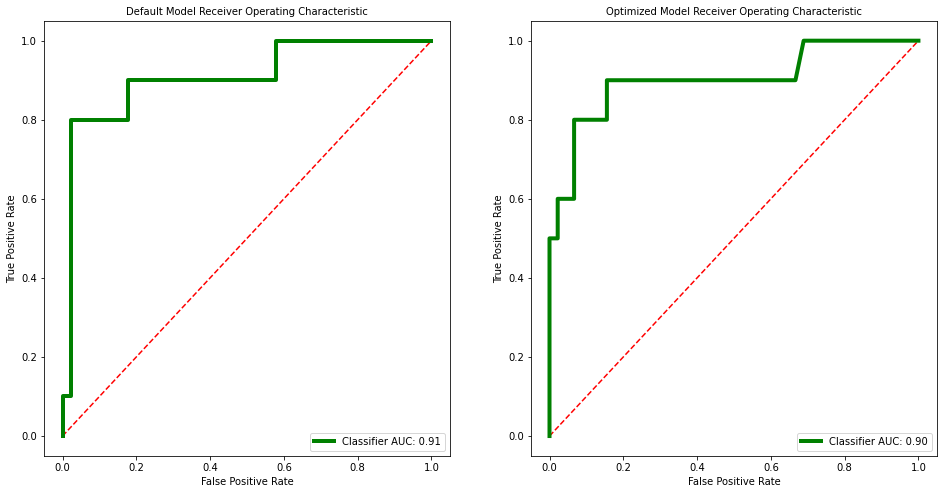

In [24]:
fig, axes = plt.subplots(1,2, figsize = (16, 8))

#Default model
axes[0].plot([0,1], [0,1], 'r--')
probs = model.predict_proba(test_features)
# Reading probability of second class
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr)

label = 'Classifier AUC:' + ' {0:.2f}'.format(roc_auc)
axes[0].plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
axes[0].set_xlabel('False Positive Rate', fontsize = 10)
axes[0].set_ylabel('True Positive Rate', fontsize = 10)
axes[0].set_title('Default Model Receiver Operating Characteristic', fontsize = 10)
axes[0].legend(loc = 'lower right', fontsize = 10)

#Optimized model
axes[1].plot([0,1], [0,1], 'r--')
probs = new_model.predict_proba(test_features)
# Reading probability of second class
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr)

label = 'Classifier AUC:' + ' {0:.2f}'.format(roc_auc)
axes[1].plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
axes[1].set_xlabel('False Positive Rate', fontsize = 10)
axes[1].set_ylabel('True Positive Rate', fontsize = 10)
axes[1].set_title('Optimized Model Receiver Operating Characteristic', fontsize = 10)
axes[1].legend(loc = 'lower right', fontsize = 10);

## Save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in the subsequent script, `4_Predict.ipynb` 


In [25]:
dump(model, 'results/ml_model.joblib')

['results/ml_model.joblib']